# PACER analysis for mCAs in patients with CHIP

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from collections import defaultdict
import statistics as stats
from collections import Counter
from scipy.stats import fisher_exact
import numpy as np
import seaborn as sns
from scipy.stats import f_oneway
import pickle

# Importing the data

In [2]:
! gsutil cp gs://fc-e44e4e80-489e-4c0f-a2a7-a96718d54f46/user/mraddatz/feb2021_files/passenger_data_11_20.tsv .

Copying gs://fc-e44e4e80-489e-4c0f-a2a7-a96718d54f46/user/mraddatz/feb2021_files/passenger_data_11_20.tsv...
/ [1 files][407.2 KiB/407.2 KiB]                                                
Operation completed over 1 objects/407.2 KiB.                                    


In [3]:
passenger_df = pd.read_csv("passenger_data_11_20.tsv", sep = '\t')
passenger_df = passenger_df.drop('Unnamed: 0',axis=1)

In [4]:
! gsutil cp gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/long.mocha.filtered.csv .

Copying gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/long.mocha.filtered.csv...
/ [1 files][  1.2 MiB/  1.2 MiB]                                                
Operation completed over 1 objects/1.2 MiB.                                      


In [5]:
mocha_df = pd.read_csv("long.mocha.filtered.csv", sep = '\t')

 # Looking through the data

## Mocha

In [6]:
mocha_df.columns

Index(['sample_id', 'computed_gender', 'chrom', 'beg_GRCh38', 'end_GRCh38',
       'length', 'p_arm', 'q_arm', 'n_sites', 'n_hets', 'n50_hets', 'bdev',
       'bdev_se', 'rel_cov', 'rel_cov_se', 'lod_lrr_baf', 'lod_baf_phase',
       'n_flips', 'baf_conc', 'lod_baf_conc', 'type', 'cf'],
      dtype='object')

In [7]:
print("Unique sample ids: " + str(len(set(mocha_df['sample_id']))))
print("Total sample ids: " + str(len(mocha_df['sample_id'])))

Unique sample ids: 8517
Total sample ids: 10115


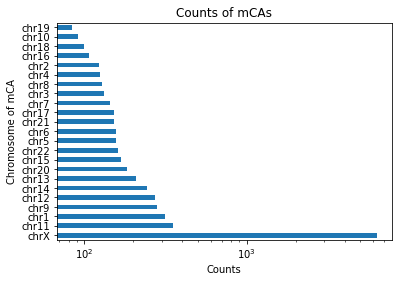

In [8]:
mocha_df['chrom'].value_counts().plot(kind='barh')
plt.xlabel('Counts')
plt.ylabel('Chromosome of mCA')
plt.xscale("log")
plt.title("Counts of mCAs")
plt.show()

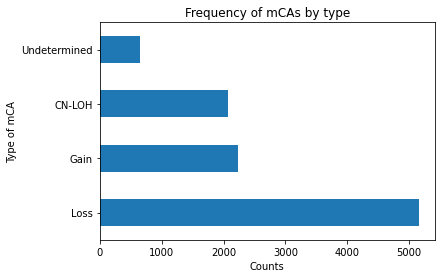

In [9]:
mocha_df['type'].value_counts().plot(kind='barh')
plt.xlabel('Counts')
plt.ylabel('Type of mCA')
plt.title('Frequency of mCAs by type')
plt.show()

In [10]:
mca_counts = defaultdict(dict)
chromosomes = list(set(mocha_df['chrom']))
mca_types = list(set(mocha_df['type']))
for chrom in chromosomes:
    for mcatype, count in mocha_df[mocha_df['chrom'] == chrom]['type'].value_counts().iteritems():
        mca_counts[chrom][mcatype] = count

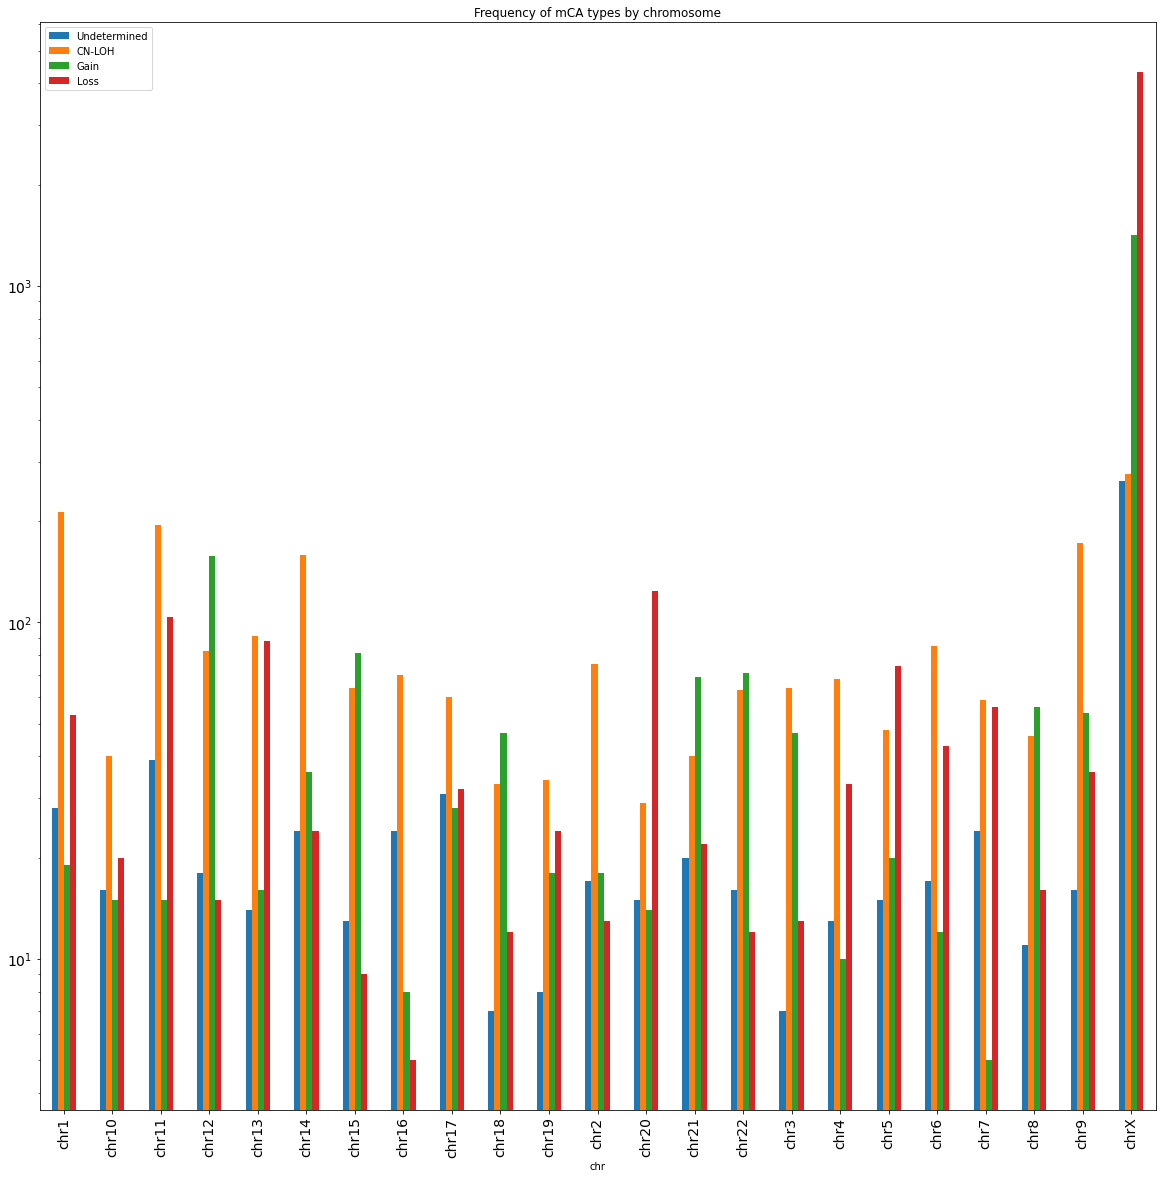

In [11]:
undet = []
cnloh = []
gain = []
loss = []
for chrom in sorted([i for i in mca_counts if mca_counts[i]!=mca_counts.default_factory()]):
    undet.append(mca_counts[chrom]['Undetermined'])
    cnloh.append(mca_counts[chrom]['CN-LOH'])
    gain.append(mca_counts[chrom]['Gain'])
    loss.append(mca_counts[chrom]['Loss'])
    
mca_counts_df = pd.DataFrame(list(zip(sorted([i for i in mca_counts if mca_counts[i]!=mca_counts.default_factory()]), undet, cnloh, gain, loss)), 
                             columns = ['chr', 'Undetermined', 'CN-LOH', 'Gain', 'Loss'])
mca_counts_df.plot(x='chr',
        kind='bar',
        stacked=False,
        title='Frequency of mCA types by chromosome', logy = True, fontsize = 14, figsize = (20, 20))

plt.show()

In [12]:
mocha_df['mca'] = mocha_df['type'] + " in " + mocha_df['chrom']

## Passenger

In [13]:
passenger_df

,sample.id,NWD_ID,total_pass_mut,subject_id,sex,POS,Gene,VAF,study,AgeAtBloodDraw,ever_smoker,pass_mut_ranknorm
0,NWD100122,NWD100122,98,770102,F,25240709,DNMT3A,0.147000,WHI,63.000000,True,-0.077226
1,NWD100133,NWD100133,62,9060,F,32434599,ASXL1,0.117000,FHS,71.147251,True,-0.827402
2,NWD100179,NWD100179,95,GS49444317,F,60663118,PPM1D,0.118000,GeneSTAR,43.000000,False,-0.130577
3,NWD100652,NWD100652,74,COPDGene_Z90569,F,25246159,DNMT3A,0.087000,COPDGene,71.000000,True,-0.533306
4,NWD100701,NWD100701,38,TPMCCDG16745,F,25241575,DNMT3A,0.155000,BioMe,68.000000,False,-1.695760
...,...,...,...,...,...,...,...,...,...,...,...,...
4365,NWD999511,NWD999511,315,15129,F,32434795,ASXL1,0.148000,FHS,84.801194,False,2.149700
4366,NWD999669,NWD999669,177,712972,F,25240367,DNMT3A,0.088000,WHI,68.000000,True,1.019891
4367,NWD999776,NWD999776,75,2256091168,M,25234307,DNMT3A,0.500000,SAPPHIRE_asthma,51.400000,False,-0.508996
4368,NWD999863,NWD999863,121,224408,F,25240430,DNMT3A,0.096000,CHS,82.000000,False,0.292944


In [14]:
print("Unique sample ids: " + str(len(set(passenger_df['sample.id']))))
print("Total sample ids: " + str(len(passenger_df['sample.id'])))

Unique sample ids: 4370
Total sample ids: 4370


In [15]:
passenger_df.columns

Index(['sample.id', 'NWD_ID', 'total_pass_mut', 'subject_id', 'sex', 'POS',
       'Gene', 'VAF', 'study', 'AgeAtBloodDraw', 'ever_smoker',
       'pass_mut_ranknorm'],
      dtype='object')

In [16]:
total_pass_mut = list(passenger_df['total_pass_mut'])

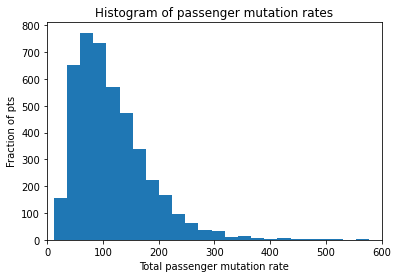

Min: 12
Max: 2369
Median: 103.0


In [17]:
plt.hist(passenger_df['total_pass_mut'], density = False, bins = 100)
plt.ylabel('Fraction of pts')
plt.xlabel('Total passenger mutation rate')
plt.xlim(0, 600)
plt.title("Histogram of passenger mutation rates")
plt.show()
print("Min: " + str(min(total_pass_mut)))
print("Max: " + str(max(total_pass_mut)))
print("Median: " + str(stats.median(total_pass_mut)))

## Get passenger mutations for CHIP genes

In [41]:
total_pass_mut_bychip = dict()

In [42]:
total_pass_mut_bychip['DNMT3A'] = np.array(passenger_df[passenger_df['Gene'] == 'DNMT3A']['total_pass_mut'])
total_pass_mut_bychip['TET2'] = np.array(passenger_df[passenger_df['Gene'] == 'TET2']['total_pass_mut'])
total_pass_mut_bychip['JAK2'] = np.array(passenger_df[passenger_df['Gene'] == 'JAK2']['total_pass_mut'])
total_pass_mut_bychip['ASXL1'] = np.array(passenger_df[passenger_df['Gene'] == 'ASXL1']['total_pass_mut'])

Dump pickle file for comparing fitness to mCAs

In [43]:
with open('total_pass_mut_bychip_dict.pickle', 'wb') as handle:
    pickle.dump(total_pass_mut_bychip, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [44]:
! gsutil cp total_pass_mut_bychip_dict.pickle gs://fc-secure-827e3d9c-02b8-499f-91af-c2142b7d2074/mCA_pacer/total_pass_mut_bychip_dict.pickle

Copying file://total_pass_mut_bychip_dict.pickle [Content-Type=application/octet-stream]...
/ [1 files][ 25.5 KiB/ 25.5 KiB]                                                
Operation completed over 1 objects/25.5 KiB.                                     


## Assessing overlap of sample ids

In [18]:
overlap = len(set(passenger_df['sample.id']).intersection(set(mocha_df['sample_id'])))/len(set(passenger_df['sample.id']))

In [19]:
print(str(len(set(passenger_df['sample.id']).intersection(set(mocha_df['sample_id'])))) + 
      " out of " + str(len(set(mocha_df['sample_id']))) + " (" + str(round(overlap*100,2)) + "%) of the patients with a mCA had a passenger rate available")

678 out of 8517 (15.51%) of the patients with a mCA had a passenger rate available


# Making new dataframe with data

## Making dictionary for mCAs by id

In [20]:
mocha_dict_by_id = defaultdict(set)

for index, row in mocha_df.iterrows():
    mca = str(row['type'] + " in " + row['chrom'])
    mocha_dict_by_id[row['sample_id']].add(mca)

In [21]:
keys = []
mcas = []
for key, value in mocha_dict_by_id.items():
    keys.append(key)
    mcas.append(', '.join(value))

mca_string_df = pd.DataFrame(zip(keys,mcas), 
                             columns = ['sample.id', 'mCAs'])
mca_string_df.head()

,sample.id,mCAs
0,NWD100095,Gain in chrX
1,NWD100109,Gain in chrX
2,NWD100133,Loss in chrX
3,NWD100227,Loss in chrX
4,NWD100329,Loss in chrX


## Combining passenger mutation rates, CHIP genes, and mCAs

In [22]:
mca_pacer_df = passenger_df.merge(mca_string_df, on="sample.id")
mca_pacer_df.head()

,sample.id,NWD_ID,total_pass_mut,subject_id,sex,POS,Gene,VAF,study,AgeAtBloodDraw,ever_smoker,pass_mut_ranknorm,mCAs
0,NWD100133,NWD100133,62,9060,F,32434599,ASXL1,0.117,FHS,71.147251,True,-0.827402,Loss in chrX
1,NWD100701,NWD100701,38,TPMCCDG16745,F,25241575,DNMT3A,0.155,BioMe,68.000000,False,-1.695760,Undetermined in chrX
2,NWD105788,NWD105788,164,TPMCCDG18111,F,105259639,TET2,0.093,BioMe,75.000000,False,0.867237,"Loss in chrX, CN-LOH in chr8"
3,NWD105842,NWD105842,86,707915,F,120254343,ZBTB33,0.103,WHI,70.000000,True,-0.291148,Loss in chrX
4,NWD109865,NWD109865,74,COPDGene_N84199,F,25241591,DNMT3A,0.162,COPDGene,60.000000,True,-0.533306,Gain in chrX


## Are any CHIP gene - mCA pairs enriched? 

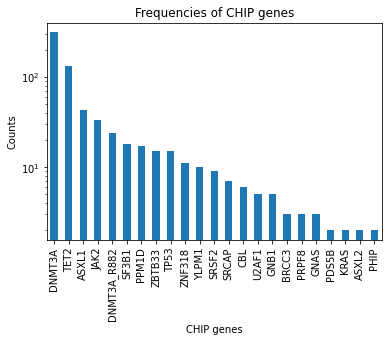

In [23]:
mca_pacer_df['Gene'].value_counts().plot(kind='bar')
plt.ylabel('Counts')
plt.xlabel('CHIP genes')
plt.yscale("log")
plt.title("Frequencies of CHIP genes")
plt.show()

In [24]:
gene_mca_pairs = defaultdict(list)
for index, row in mca_pacer_df.iterrows():
    for mca in row['mCAs'].split(", "):
        gene_mca_pairs[row['Gene']].append(mca)

In [25]:
gene_mca_counter = []
for gene in gene_mca_pairs.keys():
    counter_dict = Counter(gene_mca_pairs[gene])
    for key, item in counter_dict.items():
        gene_mca_counter.append([gene, key, item])

gene_mca_counter_df = pd.DataFrame(gene_mca_counter, columns = ['Gene', 'mCA', 'Count'])

In [26]:
gene_mca_enrichment = []
tot = gene_mca_counter_df['Count'].sum()

for index, row in gene_mca_counter_df.iterrows():
    gene_mca = row['Count']
    gene_notmca = gene_mca_counter_df[gene_mca_counter_df['Gene'] == row['Gene']]['Count'].sum() - gene_mca
    notgene_mca = gene_mca_counter_df[gene_mca_counter_df['mCA'] == row['mCA']]['Count'].sum() - gene_mca
    notgene_notmca = tot - gene_mca - gene_notmca - notgene_mca
    table = np.array([[gene_mca, gene_notmca], [notgene_mca, notgene_notmca]])
    oddsr, p = fisher_exact(table, alternative='two-sided')
    gene_mca_enrichment.append([row['Gene'], row['mCA'], oddsr, p])

Enriched mCA-CHIPgene pairs by a fisher's exact test w Bonferroni correction 

In [27]:
gene_mca_enrichment_df = pd.DataFrame(gene_mca_enrichment, columns = ['Gene', 'mCA', 'oddsR', 'p'])
gene_mca_enrichment_df[gene_mca_enrichment_df['p'] < 0.05/len(gene_mca_enrichment_df)]

,Gene,mCA,oddsR,p
32,DNMT3A,CN-LOH in chr2,17.103245,1.742186e-04
48,DNMT3A,CN-LOH in chr9,0.149066,2.060752e-05
78,TET2,CN-LOH in chr4,13.006849,1.267542e-07
150,JAK2,CN-LOH in chr9,59.590909,4.115358e-23
155,JAK2,Loss in chrX,0.074837,5.190521e-07
186,TP53,Loss in chr17,inf,4.314315e-05


### Zooming in on DNMT3A - what mCAs change the passenger mutation rate?

In [68]:
dnmt3a_chr_pacer = []
for index, row in mca_pacer_df[mca_pacer_df['Gene'] == 'DNMT3A'].iterrows():
    for mca in row['mCAs'].split(", "):
        dnmt3a_chr_pacer.append([mca, row['total_pass_mut']])

In [73]:
dnmt3a_chr_pacer_df = pd.DataFrame(dnmt3a_chr_pacer, columns = ['chr', 'pacer score'])
dnmt3a_chr_pacer_df_summary = dnmt3a_chr_pacer_df.groupby('chr').describe()['pacer score']

<BarContainer object of 57 artists>

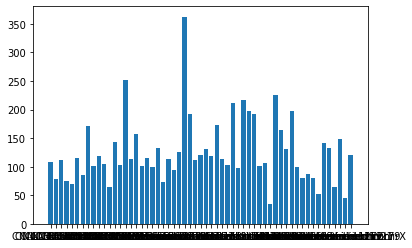

In [76]:
plt.bar(x=dnmt3a_chr_pacer_df_summary.index, height=dnmt3a_chr_pacer_df_summary['mean'])

## Does having more mCAs increase the average passenger mutation rate?

In [175]:
nummcas_mutrate = pd.DataFrame(zip(mca_pacer_df['total_pass_mut'], mca_pacer_df['mCAs'].str.count(",")), 
                               columns = ['PACER score', 'Number of mCAs'])

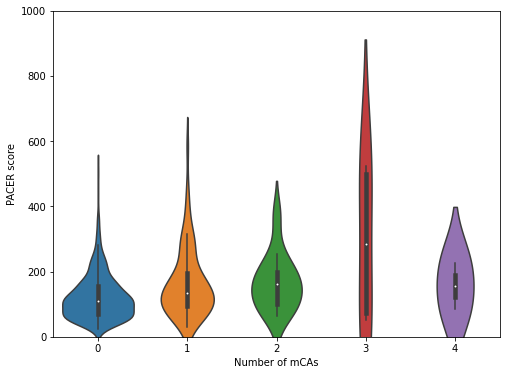

In [181]:
plt.figure(figsize=(8,6))
sns.violinplot(y="PACER score", 
                x="Number of mCAs", 
                data=nummcas_mutrate)
plt.ylim((0,1000))
plt.xlim((-0.5,4.5))
plt.show()

In [192]:
f_oneway(nummcas_mutrate[nummcas_mutrate['Number of mCAs'] == 0]['PACER score'],
         nummcas_mutrate[nummcas_mutrate['Number of mCAs'] == 1]['PACER score'],
         nummcas_mutrate[nummcas_mutrate['Number of mCAs'] == 2]['PACER score'],
         nummcas_mutrate[nummcas_mutrate['Number of mCAs'] == 3]['PACER score'],
         nummcas_mutrate[nummcas_mutrate['Number of mCAs'] == 4]['PACER score'],
         nummcas_mutrate[nummcas_mutrate['Number of mCAs'] == 5]['PACER score'])

F_onewayResult(statistic=7.962785181095918, pvalue=2.648084375228438e-07)

Significant ANOVA between the groups with a p-value of 2.65e-7

## For each type of mCA, what is the average passenger mutation rate?

In [197]:
mcas_pacerscore = []
for index, row in mca_pacer_df.iterrows():
    for mca in row['mCAs'].split(", "):
        mcas_pacerscore.append([mca, row['total_pass_mut']])
mcas_pacerscore = pd.DataFrame(mcas_pacerscore, columns = ['mCA', 'PACER score'])

In [202]:
mcas_pacerscore.groupby('mCA').describe()

PACER score                                         \
                           count        mean         std    min     25%   
mCA                                                                       
CN-LOH in chr1              15.0  122.200000   51.485365   64.0   95.00   
CN-LOH in chr10              3.0   69.000000   24.758837   50.0   55.00   
CN-LOH in chr11             16.0  180.062500  102.091115   48.0  125.25   
CN-LOH in chr12              6.0  178.000000  166.679333   58.0   70.75   
CN-LOH in chr13              6.0   95.333333   41.726091   55.0   68.00   
...                          ...         ...         ...    ...     ...   
Undetermined in chr4         2.0  136.500000   28.991378  116.0  126.25   
Undetermined in chr5         1.0  103.000000         NaN  103.0  103.00   
Undetermined in chr7         3.0  148.333333   48.850111   92.0  133.00   
Undetermined in chr9         1.0   46.000000         NaN   46.0   46.00   
Undetermined in chrX        18.0  125.388889  126.233276   30.0   56.50   

                                            
                        50%     75%    max  
mCA                                         
CN-LOH in chr1        107.0  141.50  266.0  
CN-LOH in chr10        60.0   78.50   97.0  
CN-LOH in chr11       158.0  212.00  374.0  
CN-LOH in chr12       106.5  213.50  489.0  
CN-LOH in chr13        88.5  103.00  171.0  
...                     ...     ...    ...  
Undetermined in chr4  136.5  146.75  157.0  
Undetermined in chr5  103.0  103.00  103.0  
Undetermined in chr7  174.0  176.50  179.0  
Undetermined in chr9   46.0   46.00   46.0  
Undetermined in chrX   96.0  147.00  585.0  

[77 rows x 8 columns]

## For each type of mCA on a specific chromosome, what is the average passenger mutation rate?

## What is the 